# Classificação de Flores Iris

## 📌  Objetivo do projeto

Este projeto tem como objetivo classificar espécies de flores Iris a partir de suas características morfológicas.

Modelos desse tipo podem ser valiosos para botânicos e agricultores que buscam identificar espécies de forma automática, seja por meio de imagens ou sensores.

Mais do que isso, ele abre portas para aplicações como sistemas de recomendação para cultivo e manejo.

No fundo, porém, é uma iniciativa de aprendizado e descoberta em data science e machine learning, servindo como ponto de partida para projetos futuros ainda mais desafiadores.

## 1. 📚 Preparando bibliotecas e analisando dados

### Importação de bibliotecas relevantes

In [9]:
# Importing essential libraries for analysis, visualization, and modeling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Setting Seaborn default style for better visualizations
sns.set()

#### Leitura de dados

In [11]:
# Loading the Iris dataset from Seaborn's built-in datasets
df_iris = sns.load_dataset("iris")

# Displaying the first few rows of the dataset
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Tudo certo, vamos prosseguir

## 2. 👷🏽 Tratamento dos dados 

Vamos procurar dados duplicados, nulos e outliers

### Dados Duplicados

In [16]:
# Checking for duplicated rows
duplicate_count = df_iris.duplicated().sum()

duplicate_count

1

In [17]:
# Inspecting duplicated rows (keeping all instances)
df_iris[df_iris.duplicated(keep=False)]

,sepal_length,sepal_width,petal_length,petal_width,species
101,5.8,2.7,5.1,1.9,virginica
142,5.8,2.7,5.1,1.9,virginica


In [18]:
# Note: Duplicates are identical; given the dataset size, keeping them won't significantly impact results
df_iris.drop_duplicates(inplace=True)

# Generating statistical summary of the dataset
df_iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,149.000000,149.000000,149.000000,149.000000
mean,5.843624,3.059732,3.748993,1.194631
std,0.830851,0.436342,1.767791,0.762622
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.300000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Removemos o dado duplicado, vamos seguir com a análise

### Dados nulos

In [21]:
# Checking for missing values
missing_values = df_iris.isnull().sum()

missing_values

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Nenhum dado está nulo, podemos continuar

### Outliers

Agora vamos verificar se tem outliers e se impactam bastante

Para uma abordagem mais prática e objetiva vamos visualizar um gráfico de caixa

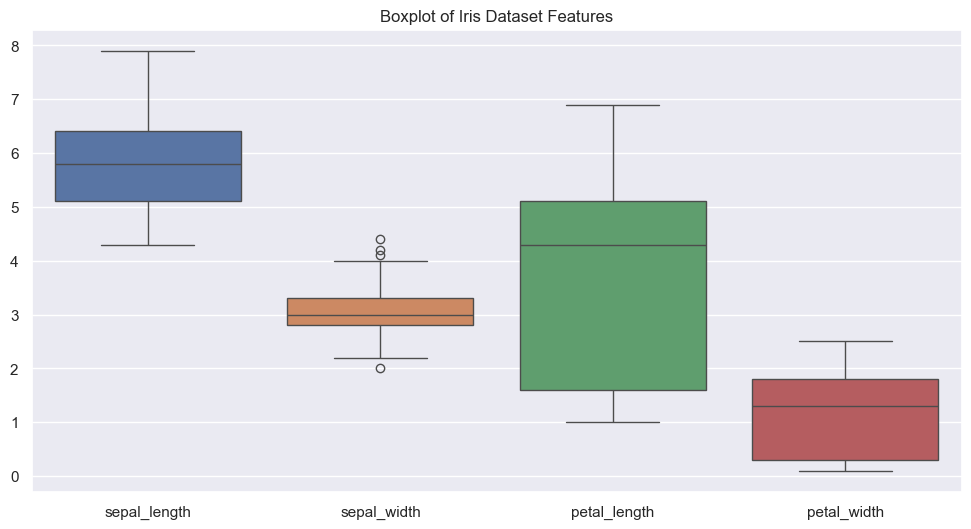

In [26]:
# Visualizing boxplots for all numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_iris)
plt.title("Boxplot of Iris Dataset Features")
plt.show()

Conseguimos ver alguns outliears na coluna sepal_width, mas não sabemos se impacta muito nos resultados

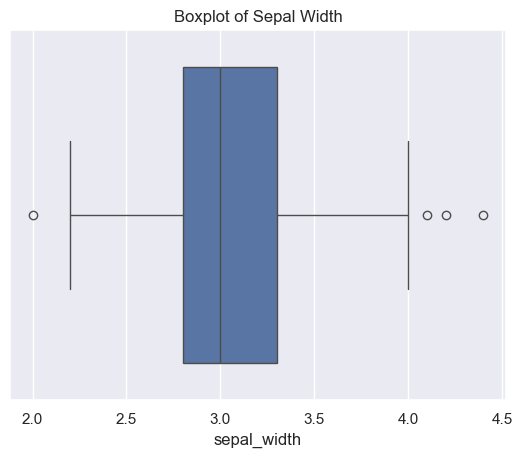

In [28]:
# Visualizing boxplot for 'sepal_width' to focus on outliers
sns.boxplot(x=df_iris["sepal_width"])
plt.title("Boxplot of Sepal Width")
plt.show()

Visualmente aparentam ser 4 outliers, removê-los não deve impactar no dataset, mas primeiro vamos confirmar a influência

In [30]:
# Calculating interquartile range (IQR) for outlier detection in 'sepal_width'
Q1 = df_iris["sepal_width"].quantile(0.25)  # First quartile (25th percentile)
Q3 = df_iris["sepal_width"].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range (middle 50% of data)

# Defining lower and upper bounds for outlier detection (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers in 'sepal_width'
outliers = df_iris[(df_iris["sepal_width"] < lower_bound) | (df_iris["sepal_width"] > upper_bound)]

# Displaying outliers
outliers

,sepal_length,sepal_width,petal_length,petal_width,species
15,5.7,4.4,1.5,0.4,setosa
32,5.2,4.1,1.5,0.1,setosa
33,5.5,4.2,1.4,0.2,setosa
60,5.0,2.0,3.5,1.0,versicolor


Conseguimos visualizar que a maioria dos outliers é da espécie setosa e possuímos um da versicolor

Agora precisamos entender a influência dos outliers nos dados, vamos criar um dataset sem eles

In [33]:
# Statistical summary with outliers
print("With outliers:")
print(df_iris["sepal_width"].describe())

# Creating a dataset without outliers
df_no_outliers = df_iris[~df_iris.index.isin(outliers.index)]

# Statistical summary without outliers
print("\nWithout outliers:")
print(df_no_outliers["sepal_width"].describe())

With outliers:
count    149.000000
mean       3.059732
std        0.436342
min        2.000000
25%        2.800000
50%        3.000000
75%        3.300000
max        4.400000
Name: sepal_width, dtype: float64

Without outliers:
count    145.000000
mean       3.042759
std        0.398216
min        2.200000
25%        2.800000
50%        3.000000
75%        3.300000
max        4.000000
Name: sepal_width, dtype: float64


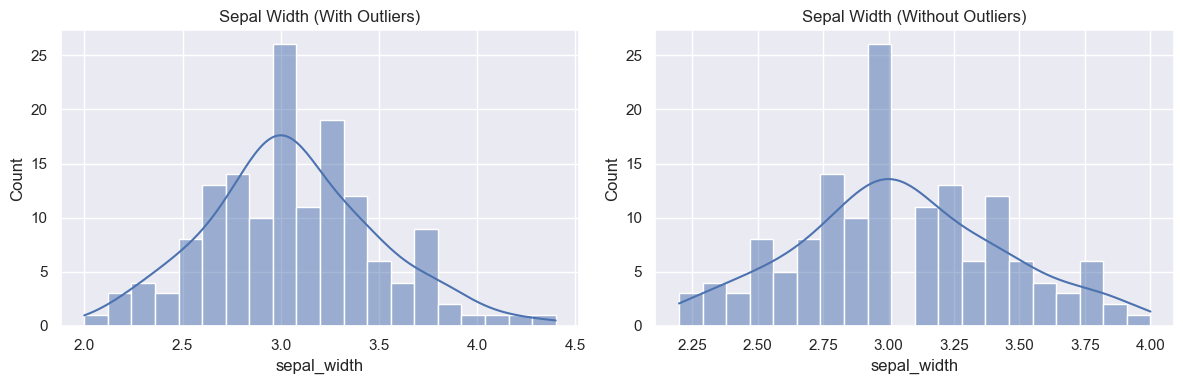

In [34]:
# Comparing histograms with and without outliers
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_iris["sepal_width"], bins=20, kde=True)
plt.title("Sepal Width (With Outliers)")

plt.subplot(1, 2, 2)
sns.histplot(df_no_outliers["sepal_width"], bins=20, kde=True)
plt.title("Sepal Width (Without Outliers)")
plt.tight_layout()
plt.show()

Em alguns pontos os outliers podem ser relativamente impactantes, depende do modelo que iremos utilizar

Para modelos que necessitam de dados mais centralizados pode ser melhor

Vamos manter ambos datasets (com e sem outliers) e vamos aplicar abordagens diferentes para cada modelo

## 3. ☯️ Separação de dados para treino e teste

#### Importar sklearn para separar os dados e preparando dados com outliers

In [40]:
# Preparing data for modeling: Features (X) and Target (y)
X = df_iris.drop('species', axis='columns')  # Independent variables (features)
y = df_iris['species']  # Dependent variable (target)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preparando dados sem outliers

In [42]:
# Preparing data without outliers for modeling
X_no_outliers = df_no_outliers.drop('species', axis='columns')
y_no_outliers = df_no_outliers['species']

# Splitting data without outliers into training and testing sets
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

## 4. 🏋🏼 Treinamento de modelos

Depois de explorar os dados na análise inicial (EDA), identificamos algumas abordagens bem promissoras para trabalhar com esse conjunto de dados:

### 4.1 Support Vector Machine (SVM) - Dataset sem outliers

Para o modelo SVM, optamos por utilizar o dataset sem outliers, pois esse algoritmo é sensível a valores extremos devido à sua dependência na maximização da margem entre as classes. A presença de outliers pode distorcer os hiperplanos de separação, puxando os vetores de suporte para posições menos representativas dos dados principais. Ao remover os outliers, obtemos um conjunto de dados mais agrupado e consistente, o que tende a melhorar o desempenho do modelo, resultando em uma classificação mais precisa e uma margem de separação mais robusta.

#### Criando modelo

In [48]:
# Initializing and training SVM model (RBF kernel for non-linear data)
svm_model = SVC(C=1, gamma='scale', random_state=42)
svm_model.fit(X_train_no_outliers, y_train_no_outliers)

# Making predictions with SVM
y_pred_svm = svm_model.predict(X_test_no_outliers)

#### Testando o Modelo

SVM Accuracy: 0.97
SVM Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         9
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.97        29
weighted avg       0.97      0.97      0.97        29



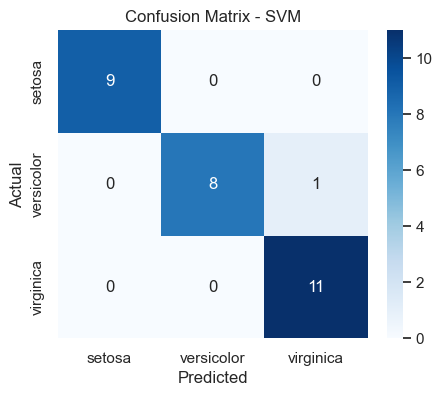

In [50]:
# Evaluating SVM model performance
svm_accuracy = accuracy_score(y_test_no_outliers, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

# Displaying classification report for SVM
print("SVM Classification Report:")
print(classification_report(y_test_no_outliers, y_pred_svm))

# Visualizing SVM confusion matrix
conf_matrix_svm = confusion_matrix(y_test_no_outliers, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_no_outliers), yticklabels=np.unique(y_no_outliers))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

Após os testes, o modelo alcançou uma eficácia de 97% no dataset sem outliers. Nada mal!

Vamos agora explorar outro modelo e ver como ele se sai em comparação.

### 4.2 K-Nearest Neighbor (K-NN) - Dataset sem outliers

Para o modelo K-NN, optamos por utilizar o dataset sem outliers, pois esse algoritmo é sensível a valores extremos devido à sua dependência na proximidade entre os pontos para determinar as classes. A presença de outliers pode influenciar desproporcionalmente as decisões de classificação, já que o modelo considera os vizinhos mais próximos com base em distâncias, como a euclidiana. Esses valores atípicos podem distorcer a vizinhança local, levando a previsões menos representativas dos padrões principais dos dados. Ao remover os outliers, obtemos um conjunto mais coeso e agrupado, o que tende a melhorar o desempenho do K-NN, resultando em uma classificação mais precisa e consistente com a estrutura real das classes

#### Preparando os dados

In [56]:
# Scaling features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_outliers)
X_test_scaled = scaler.transform(X_test_no_outliers)

#### Criando modelo

In [58]:
# Initializing and training KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_no_outliers)

KNeighborsClassifier()

In [59]:
# Making predictions with KNN
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluating KNN model performance
knn_accuracy = accuracy_score(y_test_no_outliers, y_pred_knn)
print(f"KNN Accuracy: {knn_accuracy:.2f}")

KNN Accuracy: 0.97


In [60]:
# Displaying classification report for KNN
print("\nKNN Classification Report (Test Set):")
print(classification_report(y_test_no_outliers, y_pred_knn))


KNN Classification Report (Test Set):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         9
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.97        29
weighted avg       0.97      0.97      0.97        29



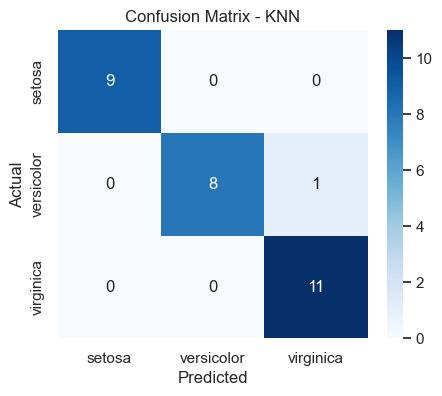

In [61]:
# Visualizing KNN confusion matrix
conf_matrix_knn = confusion_matrix(y_test_no_outliers, y_pred_knn)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_no_outliers), yticklabels=np.unique(y_no_outliers))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()

O K-NN, sem os outliers, também chegou a 97% de desempenho, empatando com o SVM. Interessante, né? 

Vamos seguir em frente e testar modelos que incluam os outliers pra ver o que muda.

### 4.2 Random Forest - Dataset com outliers

Para o modelo Random Forest, optamos por usar o dataset com outliers, pois esse algoritmo é robusto a valores extremos devido à sua natureza de ensemble. Ele combina múltiplas árvores de decisão, reduzindo o impacto de outliers ao focar nos padrões gerais dos dados, o que mantém a precisão sem necessidade de remoção prévia desses valores.

#### Criando modelo

In [67]:
# Initializing and training Random Forest model (using original data with outliers)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [68]:
# Making predictions with Random Forest
y_pred_rf = rf_model.predict(X_test)

#### Testando modelo

In [70]:
# Evaluating Random Forest model performance
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Displaying classification report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 1.00

Random Forest Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



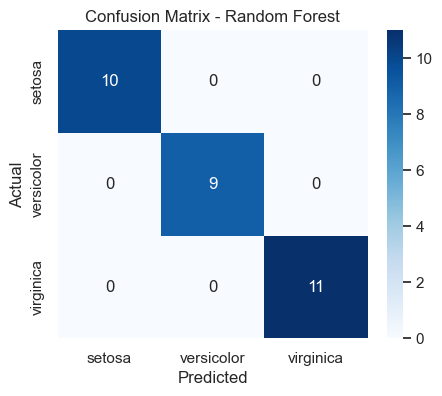

In [71]:
# Visualizing Random Forest confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

Até agora, essa foi a melhor previsão entre os modelos que testamos. Um destaque que vale a pena explorar mais!

### 4.4 Decision Trees - Dataset com outliers

Para o modelo Decision Tree, escolhemos o dataset com outliers, pois esse algoritmo é naturalmente resistente a valores extremos. Ele divide os dados com base em condições nas features, focando em padrões gerais, e outliers têm impacto limitado, já que não afetam diretamente as regras de decisão.

#### Criando o modelo

In [76]:
# Initializing and training Decision Tree model (using original data with outliers)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [77]:
# Making predictions with Decision Tree
y_pred_dt = dt_model.predict(X_test)

# Evaluating Decision Tree model performance
dt_accuracy = accuracy_score(y_test, y_pred_dt)  # Fixed to use y_pred_dt instead of y_pred_rf
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

# Displaying classification report for Decision Tree
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 1.00

Decision Tree Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



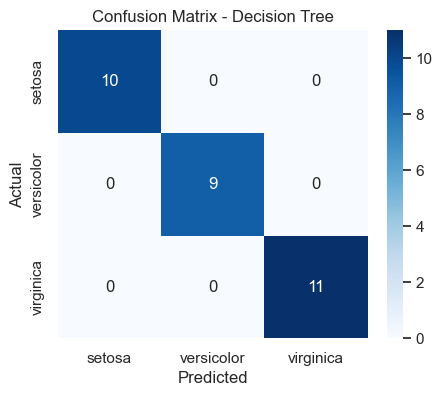

In [78]:
# Visualizing Decision Tree confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues", 
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

O modelo de árvores de decisão trouxe resultados sólidos, mas ainda há espaço para ajustar e comparar com os outros.

## 📊 Conclusão

O projeto de previsão de espécies no dataset Iris foi concluído com sucesso, abrangendo a verificação e limpeza dos dados (remoção de duplicatas e outliers em um arquivo separado), a separação adequada dos dados e a aplicação de quatro modelos de machine learning. 

O SVM e o K-NN, utilizando o dataset sem outliers, alcançaram 97% de acurácia, demonstrando bom desempenho em dados mais agrupados, embora o SVM tenha sido impactado pela falta de escalonamento.

Já o Random Forest e a Decision Tree, aplicados ao dataset com outliers, atingiram 100% de acurácia, evidenciando sua robustez a valores extremos e eficácia em capturar padrões gerais.

Esses resultados confirmam que, para o dataset Iris, modelos baseados em árvores são altamente precisos mesmo sem pré-processamento extensivo, enquanto SVM e K-NN se beneficiam da remoção de outliers.

O Random Forest se destaca como a melhor escolha geral pela combinação de precisão máxima e estabilidade.